In [309]:
import warnings
import random

import pandas as pd
import numpy as np
from scipy.stats import ttest_rel, ttest_ind, binned_statistic
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression as LR
from sklearn.preprocessing import scale
from sklearn.calibration import calibration_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from category_encoders.target_encoder import TargetEncoder
from sklearn.calibration import CalibratedClassifierCV
from plot_metric import functions
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
pd.set_option('max_columns', 50)
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [282]:
df_url = '~/Desktop/testing/dodo/data/data.csv'
df = pd.read_csv(df_url, engine='python')

print(df.shape)
df.head()

(20468, 29)


,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,maritalstatus,monthlybilledamount,noadditionallines,numberofcomplaints,numberofmonthunpaid,numdayscontractequipmentplanexpiring,occupation,penaltytoswitch,state,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn,year,month
0,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,Single,71,\N,0,7,96,Technology Related Job,371,WA,15,19,No,No,0.82,5971,663,0,2015,1
1,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,Single,71,\N,0,7,96,Technology Related Job,371,WA,15,19,No,No,0.82,3981,995,0,2015,2
2,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,Yes,Single,8,\N,1,4,14,Technology Related Job,43,WI,212,34,No,Yes,0.27,7379,737,0,2015,1
3,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,Yes,Single,8,\N,1,4,14,Technology Related Job,43,WI,212,34,No,Yes,0.27,1729,432,0,2015,2
4,58,27076,0.07,0.02,4251055773,3,Yes,Master or equivalent,Female,Yes,Single,16,\N,0,2,55,Technology Related Job,403,KS,216,144,No,No,0.48,3122,624,0,2015,1


# Feature engineering ideas 

# Baseline model

## Данные для baseline'а

In [284]:
df_upd = df.copy()
df_upd.drop(columns=['noadditionallines'], inplace=True)

df_upd.shape

(20468, 28)

In [269]:
exclude_fs = ['customerid', 'churn', 'year', 'month']

cat_features = df_upd.select_dtypes(include=["bool", "object"]).columns.tolist()
num_features = [col for col in df_upd.select_dtypes(include=["int64", "float64"]).columns.tolist() if col not in exclude_fs+['callingnum']]

len(cat_features), len(num_features)

(9, 14)

## Параметры и инициализация

In [285]:
params = {
    'params_clf': {
        'solver': 'liblinear',
        'penalty': 'l1',
        'C': 1,
        'class_weight': {
            1: df_upd.shape[0]/(2 * df_upd.loc[df_upd.churn == 1, 'churn'].shape[0]),
            0: df_upd.shape[0]/(2 * df_upd.loc[df.churn == 0, 'churn'].shape[0])
        },
        'n_jobs': 4,
        'random_state': 42
    },
    'params_skf': {
        'n_splits': 5,
        'shuffle': True,
        'random_state': 42
    }
}

skf = StratifiedKFold(**params['params_skf'])

# Используем ЛогРег в качестве бейзлайна
clf_baseline = LR(**params['params_clf'])

# В качестве кодировщика кат фичей используем target encoder,
t_encoder = TargetEncoder(return_df=True)

## Функции для обучения и отрисовки графиков

In [286]:
def plt_roc_auc_curve(y_test, y_probs, y_train, y_train_probs):    
    auc_score = roc_auc_score(y_test, y_probs)
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    
    auc_score1 = roc_auc_score(y_train, y_train_probs)
    fpr1, tpr1, _ = roc_curve(y_train, y_train_probs)
    
    plt.figure(figsize=(8, 8))
    plt.plot([0,1], [0,1], linestyle='--', label='Random model')
    plt.plot(fpr, tpr, label='Test AUC-ROC curve', color='r');
    plt.plot(fpr1, tpr1, label='Train AUC-ROC curve', color='b');
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    props = {
            'boxstyle': 'round', 
            'facecolor': 'wheat', 
            'alpha': 0.5
            }
    
    plt.text(0.05, 0.95, f'Test AUC-ROC score: { auc_score.round(3) }\nTrain AUC-ROC score: { auc_score1.round(3) }', fontsize=12,
            verticalalignment='top', bbox=props)

In [341]:
def preproc_train_bl(X, y, num_features_list, cat_features_list):
    '''
    Препроцессинг трейна
    
    :param pd.DataFrame X: ...
    
    :return: ...
    '''
    # В качестве кодировщика кат фичей используем target encoder,
    t_encoder = TargetEncoder(return_df=True)
    t_encoder_fitted = t_encoder.fit(X[cat_features_list], y)
    encoded_cat_features = t_encoder_fitted.transform(X[cat_features_list]).reset_index(drop=True)
    scaled_features_c = pd.DataFrame(
                                    scale(encoded_cat_features),
                                    columns=cat_features_list
                            )
    
    scaled_features_n = pd.DataFrame(
    scale(X[[c for c in num_features_list if c not in ['year', 'month']]]),
    columns=[c for c in num_features_list if c not in ['year', 'month']]
                            )
    
    X_p = pd.concat([scaled_features_c, scaled_features_n], axis=1, ignore_index=True)
    X_p.columns = cat_features_list + num_features_list
    
    return_dict = {
        'X': X_p,
        'y': y,
        'cat_encoder': t_encoder_fitted
                  }
    
    return return_dict


def preproc_test_bl(X, num_features_list, cat_features_list, cat_encoder):
    '''
    Препроцессинг теста
    
    :param pd.DataFrame X: ...
    
    :return: ...
    '''
    encoded_cat_features = cat_encoder.transform(X[cat_features_list]).reset_index(drop=True)
    scaled_features_c = pd.DataFrame(
                                    scale(encoded_cat_features),
                                    columns=cat_features_list
                            )
    
    scaled_features_n = pd.DataFrame(
        scale(X[[c for c in num_features_list if c not in ['year', 'month']]]),
        columns=[c for c in num_features_list if c not in ['year', 'month']]
                                )
    X_p = pd.concat([scaled_features_c, scaled_features_n], axis=1, ignore_index=True)
    X_p.columns = cat_features_list + num_features_list
    
    return X_p

In [292]:
def ts_crossval(df, target_col_name, split_col_cv, num_features, cat_features):
    '''
    Кросс валидация для временного ряда: сначала обучаемся на 1 дате (месяце)
    и предсказываем 2 дату, затем обучаемся на 2 датах и предсказываем 3
    '''
    sorted_months_val = sorted(df[split_col_cv].unique())
    months_val = []
    roc_auc_scores = []
    for index_, i in enumerate(sorted_months_val):
#         последний элемент
        if index_ == len(sorted_months_val)-1:
            break
        else:
            clf_baseline = LR(**params['params_clf'])
            months_val.append(i)
            X_train, X_test, y_train, y_test = df_upd[df_upd.month.isin(months_val)], \
                df_upd[df_upd.month == sorted_months_val[index_+1]], \
                df_upd.loc[df_upd.month.isin(months_val), target_col_name], \
                df_upd.loc[df_upd.month == sorted_months_val[index_+1], target_col_name]

            train_data = preproc_train_bl(X_train, y_train, num_features, cat_features)
            test_data = preproc_test_bl(X_test, num_features, cat_features, train_data['cat_encoder'])
    
            clf_baseline_fitted = clf_baseline.fit(train_data['X'], train_data['y'])
            roc_auc_scores.append(roc_auc_score(y_test, clf_baseline_fitted.predict_proba(test_data)[:, 1]))
    
    return roc_auc_scores

## Обучение и проверки

In [293]:
crossval_score = ts_crossval(
                            df_upd, 
                            'churn', 
                            'month', 
                            num_features, 
                            cat_features
    )

crossval_score

[0.6752096426184477, 0.7108109416606149]

In [294]:
np.mean(crossval_score), np.std(crossval_score), np.std(crossval_score)/np.mean(crossval_score)

(0.6930102921395314, 0.017800649521083567, 0.02568598146807835)

In [296]:
X_train, X_test, y_train, y_test = df_upd[df_upd.month == 1], \
    df_upd[df_upd.month == 2], \
    df_upd.loc[df_upd.month == 1, 'churn'], \
    df_upd.loc[df_upd.month == 2, 'churn']

train_data = preproc_train_bl(X_train, y_train, num_features, cat_features)

clf_baseline_fitted = clf_baseline.fit(train_data['X'], train_data['y'])

In [297]:
test_data = preproc_test_bl(X_test, num_features, cat_features, train_data['cat_encoder'])

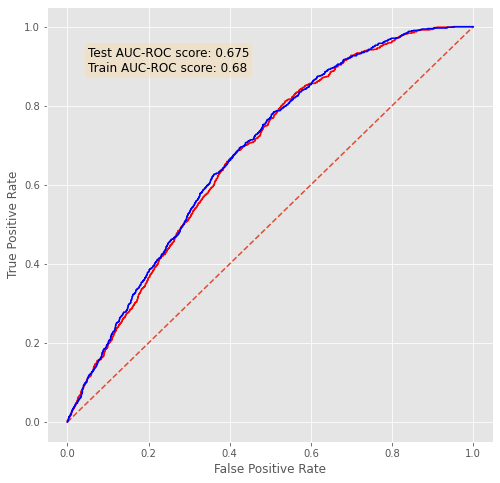

In [298]:
plt_roc_auc_curve(y_test, clf_baseline_fitted.predict_proba(test_data)[:, 1], y_train, clf_baseline_fitted.predict_proba(train_data['X'])[:, 1])

In [301]:
bc = functions.BinaryClassification(
                                    y_test,
                                    clf_baseline_fitted.predict_proba(test_data)[:, 1],
                                    labels=[0,1],
                                    threshold=.5
                            )

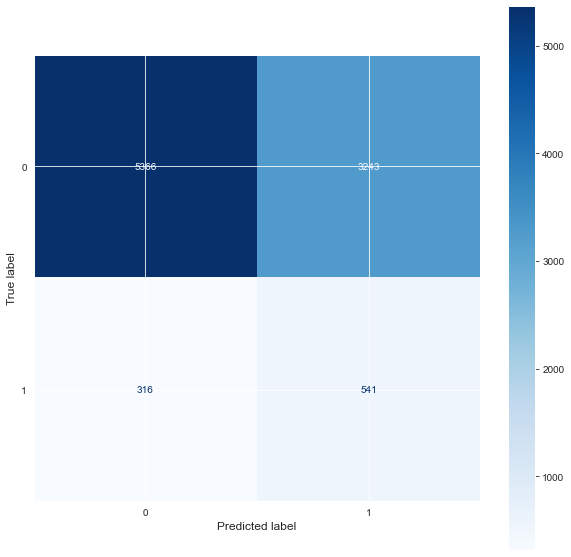

In [302]:
fig, ax = plt.subplots(
    figsize=(10, 10),
)

plot_confusion_matrix(
    clf_baseline_fitted,
    test_data,
    y_test,
    cmap='Blues',
    ax=ax
);

In [303]:
print(metrics.classification_report(
    y_test,
    clf_baseline_fitted.predict_proba(test_data)[:, 1].round(0)
))

              precision    recall  f1-score   support

           0       0.94      0.62      0.75      8609
           1       0.14      0.63      0.23       857

    accuracy                           0.62      9466
   macro avg       0.54      0.63      0.49      9466
weighted avg       0.87      0.62      0.70      9466



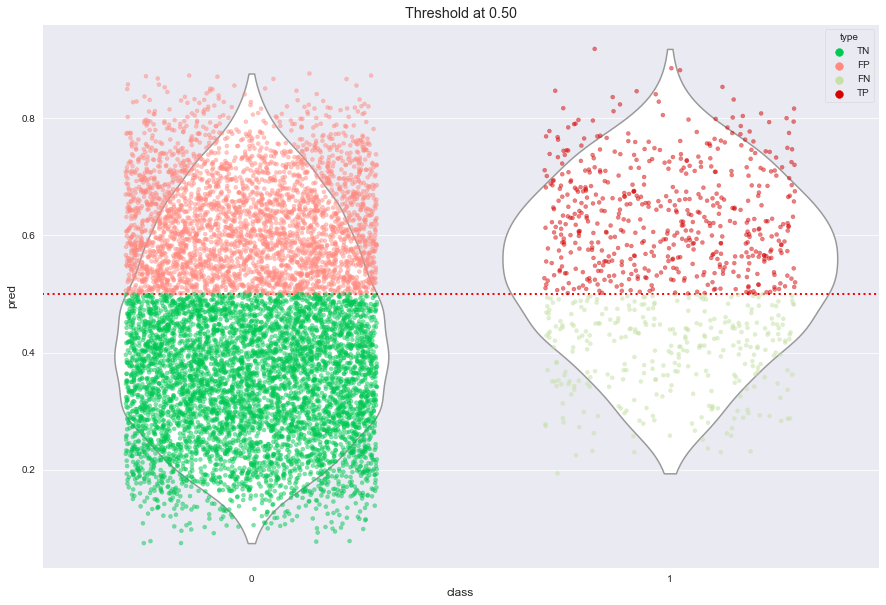

In [304]:
plt.figure(figsize=(15, 10));
bc_class_dit = bc.plot_class_distribution()

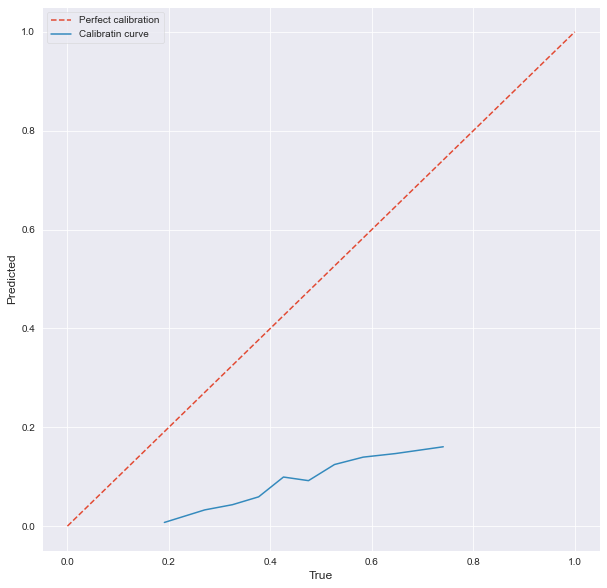

In [322]:
# Проверим, насколько модель уверена в своих предсказаниях. Для этого построим calibration_curve

y_means, proba_means = calibration_curve(
    y_test,
    clf_baseline_fitted.predict_proba(test_data)[:, 1],
    n_bins=10, 
    strategy='quantile'
)

plt.figure(figsize=(10,10))
plt.plot([0,1], [0,1], linestyle='--', label='Perfect calibration')
plt.plot(proba_means, y_means, label='Calibratin curve');
plt.xlabel('True');
plt.ylabel('Predicted');
plt.legend();

In [317]:
calibrated_clf = CalibratedClassifierCV(
    clf_baseline_fitted,
    'sigmoid',
    cv=skf
)

calibrated_clf.fit(
    train_data['X'], 
    train_data['y']
)

CalibratedClassifierCV(base_estimator=LogisticRegression(C=1,
                                                         class_weight={0: 0.550067186240258,
                                                                       1: 5.493290391841117},
                                                         n_jobs=4, penalty='l1',
                                                         random_state=42,
                                                         solver='liblinear'),
                       cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True))

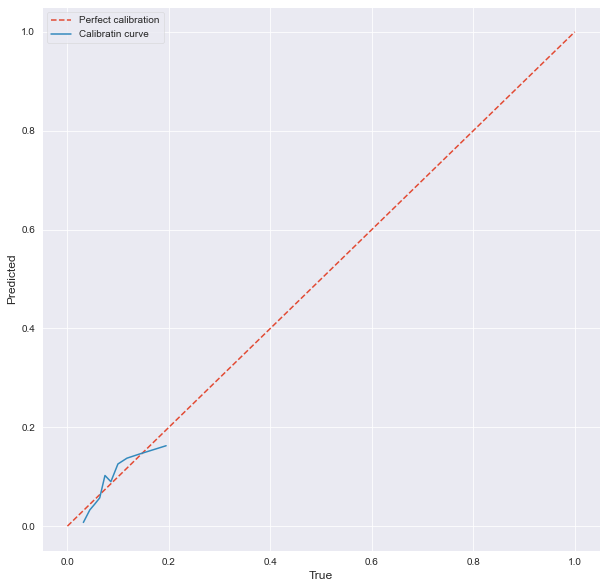

In [324]:
y_means, proba_means = calibration_curve(
    y_test,
    calibrated_clf.predict_proba(test_data)[:, 1],
    n_bins=10, 
    strategy='quantile'
)

plt.figure(figsize=(10,10))
plt.plot([0,1], [0,1], linestyle='--', label='Perfect calibration')
plt.plot(proba_means, y_means, label='Calibratin curve');
plt.xlabel('True');
plt.ylabel('Predicted');
plt.legend();

## Попробуем обучить модель на фичах с весом больше .05

In [325]:
feature_imp = pd.DataFrame({
    'col_name': cat_features+num_features, 
    'col_coef': abs(clf_baseline_fitted.coef_[0])
}).sort_values(by='col_coef', ascending=False)

feature_imp

,col_name,col_coef
9,age,0.557334
14,numberofcomplaints,0.259190
6,state,0.258937
19,unpaidbalance,0.219533
1,education,0.111662
22,avgcallduration,0.081170
4,maritalstatus,0.072593
5,occupation,0.060925
7,usesinternetservice,0.058813
16,numdayscontractequipmentplanexpiring,0.053101


In [328]:
zero_fs = set(feature_imp.loc[feature_imp.col_coef >= .05, 'col_name'].values)

zero_fs

{'age',
 'avgcallduration',
 'education',
 'maritalstatus',
 'numberofcomplaints',
 'numdayscontractequipmentplanexpiring',
 'occupation',
 'state',
 'unpaidbalance',
 'usesinternetservice'}

In [342]:
train_data_1 = preproc_train_bl(
    X_train[zero_fs], 
    y_train,
    num_features_list=[c for c in num_features if c in zero_fs],
    cat_features_list=[c for c in cat_features if c in zero_fs]
)

test_data_1 = preproc_test_bl(
    X_test[zero_fs],
    [c for c in num_features if c in zero_fs],
    [c for c in cat_features if c in zero_fs],
    train_data_1['cat_encoder']
                         )

clf_baseline_fitted_1= clf_baseline.fit(train_data_1['X'], train_data_1['y'])

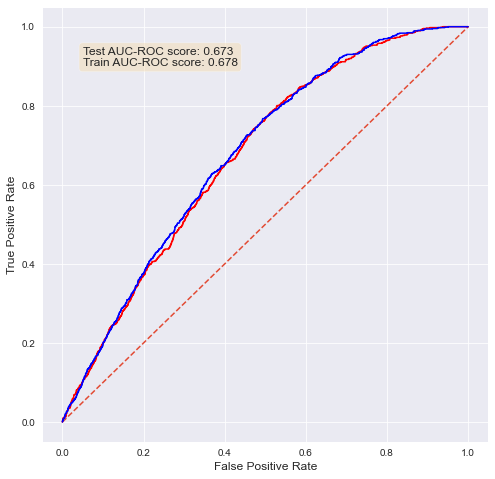

In [343]:
plt_roc_auc_curve(y_test, clf_baseline_fitted_1.predict_proba(test_data_1)[:, 1], y_train, clf_baseline_fitted_1.predict_proba(train_data_1['X'])[:, 1])

In [344]:
test_data_1

,education,maritalstatus,occupation,state,usesinternetservice,age,numberofcomplaints,numdayscontractequipmentplanexpiring,unpaidbalance,avgcallduration
0,0.701782,0.978883,-0.983688,0.136857,-0.200834,-1.700593,-1.342038,1.612614,-1.533592,1.306704
1,0.701782,0.978883,-0.983688,-0.125275,-0.200834,-0.170451,-0.447913,-1.224915,-1.320277,-1.385052
2,-2.207399,0.978883,-0.983688,-0.022889,-0.200834,0.645626,-1.342038,0.193850,0.244031,-0.806540
3,1.490450,0.978883,-0.983688,0.968156,4.979248,-1.292555,-0.447913,0.816722,0.457346,0.556072
4,0.097958,-1.021572,-0.983688,1.048151,-0.200834,-0.476479,-1.342038,-1.224915,-1.533592,0.694724
...,...,...,...,...,...,...,...,...,...,...
9461,0.701782,-1.021572,1.471669,-1.549955,-0.200834,-0.884517,1.340338,-1.294123,-0.353250,0.556072
9462,0.701782,0.978883,1.471669,0.208497,-0.200834,-0.731503,-1.342038,1.128158,0.144484,-0.199341
9463,0.701782,-1.021572,1.471669,0.986915,-0.200834,-0.629493,-0.447913,0.055434,0.642219,0.613445
9464,-2.207399,0.978883,-0.983688,-1.210556,-0.200834,0.186583,-1.342038,1.439594,-1.348719,-0.012878


In [347]:
feature_imp = pd.DataFrame({
    'col_name': test_data_1.columns, 
    'col_coef': abs(clf_baseline_fitted_1.coef_[0])
}).sort_values(by='col_coef', ascending=False).reset_index(drop=True)

feature_imp

,col_name,col_coef
0,age,0.556317
1,numberofcomplaints,0.259120
2,state,0.256468
3,unpaidbalance,0.216305
4,education,0.109929
5,avgcallduration,0.095455
6,maritalstatus,0.074902
7,usesinternetservice,0.059795
8,occupation,0.059255
9,numdayscontractequipmentplanexpiring,0.052173


## Посмотрим, что будет, если попробовать провалидироваться на 3 месяце

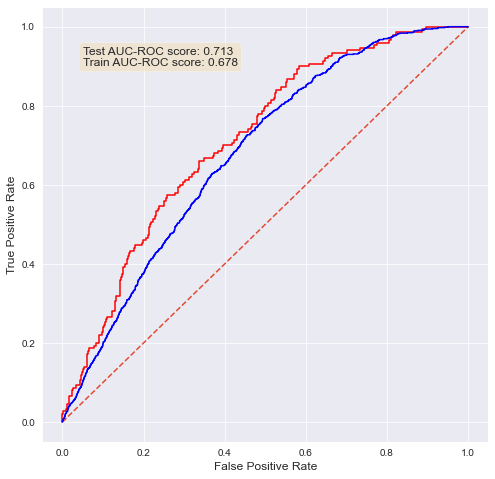

In [348]:
val_data = preproc_test_bl(
    df_upd.loc[df_upd.month == 3, zero_fs], 
    [i for i in num_features if i in zero_fs], 
    [i for i in cat_features if i in zero_fs], 
    train_data_1['cat_encoder']
)

plt_roc_auc_curve(
    df_upd.loc[df_upd.month == 3, 'churn'], 
    clf_baseline_fitted_1.predict_proba(val_data)[:, 1], 
    y_train, 
    clf_baseline_fitted_1.predict_proba(train_data_1['X'])[:, 1]
)

# Выводы

- такой способ деления выборки кажется более валидным, поэтому попробуем альтернативный алгоритм - LightGBM
- усложним модель, добавив фичей